In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
!pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
import pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-sgu3k_vh
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-sgu3k_vh
     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp36-none-any.whl size=75766 sha256=0dc52ad800b26551a0d4025a51b943bcfcadee36a890a9972b4cf29d9d8aaffb
  Stored in directory: /tmp/pip-ephem-wheel-cache-jd_1qiy4/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
  Created wheel for empyrical: filename=empyrical-0.5.5-cp36-none-any.whl size=39767 sha256=298ae454f73bfa888965cbdeb5b1441eb18090c934b340811a3434df226d2480
  Stored in directory: /root/.cache/pip/wheels/ea/b2/c8/6769d8444d2f2e608fae2641833110668d0ffd1abeb2e9f3fc
Successfully built pyfolio empyrical


/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [4]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [5]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [6]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [7]:
def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv('results/first_run/account_value_trade_{}_{}.csv'.format(model_name,i))
        df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[42:].reset_index(drop=True))
    return df_account_value

In [8]:
!cp -a "drive/My Drive/Backtest_42/model/" .
!cp -a "drive/My Drive/Backtest_42/preprocessing/" .
!cp -a "drive/My Drive/Backtest_42/config/" .
!cp -a "drive/My Drive/Backtest_42/env/" .
!cp -a "drive/My Drive/Backtest_42/data/" .
!cp -a "drive/My Drive/Backtest_42/results/" .

## DJIA

In [9]:
dji = pd.read_csv("data/^DJI.csv")
test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-06-30')]
test_dji = test_dji.reset_index(drop=True)

In [10]:
test_dji.shape

(1131, 7)

In [11]:
test_dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000
4,2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000


In [12]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [13]:
dow_strat = backtest_strat(test_dji)

## Ensemble Strategy

In [14]:
df=pd.read_csv('data/dow_30_2009_2020.csv')

In [15]:
rebalance_window = 42
validation_window = 42
unique_trade_date = df[(df.datadate > 20151001)&(df.datadate <= 20200707)].datadate.unique()


In [16]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [17]:
ensemble_account_value = get_account_value('ensemble')

0.41202719086088885


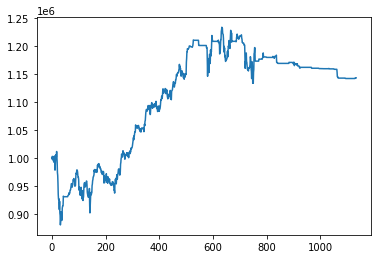

In [18]:
ensemble_account_value.account_value.plot()

In [19]:
ensemble_account_value = get_daily_return(ensemble_account_value)

Sharpe:  0.41202719086088885


In [20]:
ensemble_account_value['Date'] = test_dji['Date']

In [21]:
ensemble_account_value.head()

,account_value,datadate,daily_return,Date
0,1.000000e+06,20151202,NaN,2016-01-04
1,9.984578e+05,20151203,-0.001542,2016-01-05
2,1.003340e+06,20151204,0.004890,2016-01-06
3,1.001192e+06,20151207,-0.002141,2016-01-07
4,9.969183e+05,20151208,-0.004269,2016-01-08


In [22]:
ensemble_strat = backtest_strat(ensemble_account_value[0:1097])

In [23]:
#ensemble_account_value.to_csv('results/df_account_value_ensemble_daily_return.csv',index=False)

Start date,2016-01-04
End date,2020-05-12
Total months,52
,Backtest
Annual return,3.099%
Cumulative returns,14.206%
Annual volatility,8.137%
Sharpe ratio,0.42
Calmar ratio,0.24
Stability,0.67
Max drawdown,-12.931%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.93,2016-01-29,2016-02-19,2017-01-23,257
1,8.10,2018-07-10,2018-12-26,NaT,NaN
2,5.34,2018-02-06,2018-04-24,2018-05-16,72
3,2.70,2018-05-16,2018-06-27,2018-07-06,38
4,2.52,2016-01-19,2016-01-21,2016-01-26,6


/usr/local/lib/python3.6/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


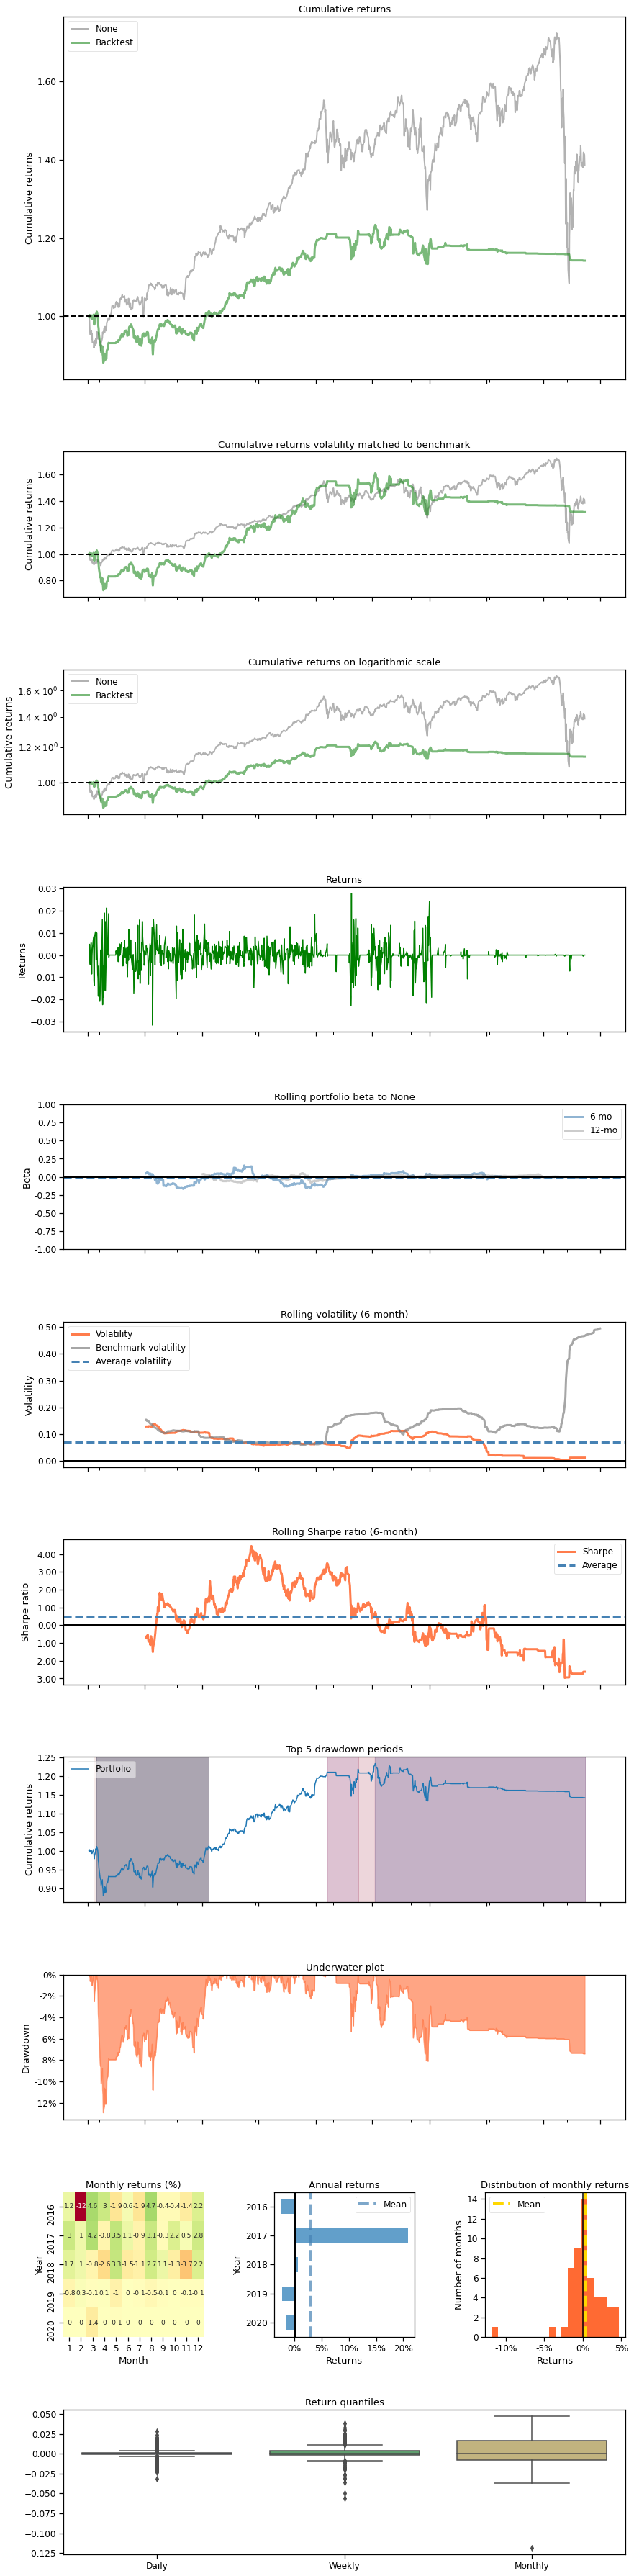

In [24]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat,
                                   benchmark_rets=dow_strat, set_context=False)